<a href="https://colab.research.google.com/github/debashisdotchatterjee/An-Elastic-Net-Penalized-Logistic-Regression-for-Epidemiological-Risk-Factors.ipynb/blob/main/(Simulation_code)_An_Elastic%E2%80%93Net_Penalized_Logistic_Regression_for_Stable_Identification_of_High_Dimensional_Epidemiological_Risk_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# Colab Simulation Notebook
# =========================
import os, time, json, math, shutil, zipfile
from dataclasses import dataclass
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

# Colab download helper (safe if not in Colab)
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

SEED = 123
rng_global = np.random.default_rng(SEED)

# ---- output folder
stamp = time.strftime("%Y%m%d_%H%M%S")
OUTDIR = f"sim_outputs_{stamp}"
FIGDIR = os.path.join(OUTDIR, "figs")
TABDIR = os.path.join(OUTDIR, "tables")
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(TABDIR, exist_ok=True)

def save_fig(name, dpi=180):
    path = os.path.join(FIGDIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    return path

def save_table(df, name):
    csv_path = os.path.join(TABDIR, f"{name}.csv")
    tex_path = os.path.join(TABDIR, f"{name}.tex")
    df.to_csv(csv_path, index=False)
    try:
        df.to_latex(tex_path, index=False, float_format="%.4f")
    except Exception:
        pass
    return csv_path

print("Output folder:", OUTDIR)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(Cell 1) Setup of Simulation

from google.colab import drive
drive.mount('/content/drive')

(Cell 2) Simulator: block-correlated X, logistic Y

In [ ]:
@dataclass
class SimConfig:
    n: int = 600
    G: int = 10          # number of groups
    m: int = 6           # group size -> p = G*m
    rho: float = 0.6     # within-group correlation
    n_active_groups: int = 3
    beta_signal: float = 1.0
    prevalence: float = 0.35

def block_cov(G, m, rho):
    """Block compound-symmetry covariance with within-block corr=rho."""
    p = G*m
    Sigma = np.eye(p)
    for g in range(G):
        idx = slice(g*m, (g+1)*m)
        Sigma[idx, idx] = rho*np.ones((m,m)) + (1-rho)*np.eye(m)
    return Sigma

def simulate_dataset(cfg: SimConfig, seed: int):
    rng = np.random.default_rng(seed)
    p = cfg.G * cfg.m
    Sigma = block_cov(cfg.G, cfg.m, cfg.rho)

    # Cholesky for MVN
    L = np.linalg.cholesky(Sigma + 1e-10*np.eye(p))
    Z = rng.normal(size=(cfg.n, p))
    X = Z @ L.T

    # choose active groups
    active_groups = rng.choice(cfg.G, size=cfg.n_active_groups, replace=False)
    beta = np.zeros(p)
    for g in active_groups:
        beta[g*cfg.m:(g+1)*cfg.m] = cfg.beta_signal  # group-wise equal signal

    # intercept for approx prevalence (since E[X beta]=0 for centered Gaussian)
    b0 = math.log(cfg.prevalence/(1-cfg.prevalence))

    eta = b0 + X @ beta
    p1 = 1/(1+np.exp(-eta))
    y = rng.binomial(1, p1, size=cfg.n)

    # group labels for later
    groups = np.repeat(np.arange(cfg.G), cfg.m)
    is_true = (beta != 0).astype(int)

    return X, y, beta, active_groups, groups, is_true


(Cell 3) Fitters (Elastic Net CV + Lasso CV) and bootstrap stability

In [ ]:
def fit_cv_model(Xtr, ytr, method: str, seed: int, cv_splits=5):
    """
    method: 'elasticnet' or 'lasso'
    returns: best_estimator (pipeline), best_params, coef (1D)
    """
    base = LogisticRegression(
        solver="saga",
        max_iter=5000,
        random_state=seed,
        n_jobs=-1,
        fit_intercept=True
    )

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", base)
    ])

    Cs = np.logspace(-3, 2, 12)

    if method == "elasticnet":
        pipe.set_params(clf__penalty="elasticnet")
        param_grid = {
            "clf__C": Cs,
            "clf__l1_ratio": [0.2, 0.5, 0.8]
        }
    elif method == "lasso":
        pipe.set_params(clf__penalty="l1")
        param_grid = {"clf__C": Cs}
    else:
        raise ValueError("method must be 'elasticnet' or 'lasso'")

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    gs = GridSearchCV(
        pipe, param_grid=param_grid, scoring="roc_auc",
        cv=cv, n_jobs=-1, refit=True
    )
    gs.fit(Xtr, ytr)

    best = gs.best_estimator_
    coef = best.named_steps["clf"].coef_.ravel().copy()
    return best, gs.best_params_, coef

def selected_set(coef, thr=1e-8):
    return set(np.where(np.abs(coef) > thr)[0].tolist())

def jaccard(a: set, b: set):
    if len(a)==0 and len(b)==0:
        return 1.0
    return len(a & b) / max(1, len(a | b))

def bootstrap_stability(Xtr, ytr, fitted_pipe, B=80, seed=0):
    """
    Bootstrap resample train set and refit with FIXED hyperparams (=fitted_pipe).
    Returns inclusion freq, sign stability, OR quantiles, and Jaccard to full model.
    """
    rng = np.random.default_rng(seed)
    n = Xtr.shape[0]
    p = Xtr.shape[1]

    # full fit on training (already fitted)
    full_coef = fitted_pipe.named_steps["clf"].coef_.ravel().copy()
    full_sel = selected_set(full_coef)

    coefs = np.zeros((B, p))
    jac = np.zeros(B)

    # clone-like: rebuild a pipeline with same hyperparams
    clf = fitted_pipe.named_steps["clf"]
    scaler = fitted_pipe.named_steps["scaler"]

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        Xb, yb = Xtr[idx], ytr[idx]

        # re-fit scaler + clf with same params
        pipe_b = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(**clf.get_params()))
        ])
        pipe_b.fit(Xb, yb)
        cb = pipe_b.named_steps["clf"].coef_.ravel()
        coefs[b] = cb
        jac[b] = jaccard(full_sel, selected_set(cb))

    incl = (np.abs(coefs) > 1e-8).mean(axis=0)
    sign_full = np.sign(full_coef)
    sign_stab = (np.sign(coefs) == sign_full).mean(axis=0)

    OR = np.exp(coefs)
    OR_lo = np.quantile(OR, 0.025, axis=0)
    OR_hi = np.quantile(OR, 0.975, axis=0)
    OR_med = np.quantile(OR, 0.50, axis=0)

    return {
        "full_coef": full_coef,
        "incl_freq": incl,
        "sign_stab": sign_stab,
        "OR_med": OR_med,
        "OR_lo": OR_lo,
        "OR_hi": OR_hi,
        "jac_to_full": jac
    }


(Cell 4) One full simulation run across correlation scenarios (tables + plots + saved zip)

In [ ]:
# ----- knobs (adjust freely)
R = 50            # Monte Carlo replicates per rho (increase for quality)
B = 80            # bootstraps for stability per replicate (increase for paper-quality)
rhos = [0.0, 0.3, 0.6, 0.9]

cfg_base = SimConfig(n=600, G=10, m=6, n_active_groups=3, beta_signal=1.0, prevalence=0.35)

all_rows = []
example_heatmaps = {}  # store one example for heatmap per rho

for rho in rhos:
    for r in range(R):
        cfg = SimConfig(**{**cfg_base.__dict__, "rho": float(rho)})
        seed = int(10_000*rho + r + 100)

        X, y, beta_true, active_groups, groups, is_true = simulate_dataset(cfg, seed=seed)

        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.30, random_state=seed, stratify=y
        )

        for method in ["elasticnet", "lasso"]:
            pipe, best_params, coef = fit_cv_model(Xtr, ytr, method=method, seed=seed)
            # test AUC
            p_te = pipe.predict_proba(Xte)[:, 1]
            auc = roc_auc_score(yte, p_te)

            sel = selected_set(coef)
            true = set(np.where(beta_true != 0)[0].tolist())

            tp = len(sel & true)
            fp = len(sel - true)
            fn = len(true - sel)

            tpr = tp / max(1, len(true))
            fdr = fp / max(1, len(sel))

            # bootstrap stability on training set with fixed hyperparams
            stab = bootstrap_stability(Xtr, ytr, pipe, B=B, seed=seed+777)

            # group recovery (fraction of variables selected inside truly active groups)
            group_rec = []
            for g in active_groups:
                idx = set(range(g*cfg.m, (g+1)*cfg.m))
                group_rec.append(len(sel & idx) / cfg.m)
            group_rec_mean = float(np.mean(group_rec)) if group_rec else 0.0

            row = {
                "rho": rho,
                "rep": r,
                "method": method,
                "auc": auc,
                "n_selected": len(sel),
                "TPR": tpr,
                "FDR": fdr,
                "mean_jaccard_to_full": float(np.mean(stab["jac_to_full"])),
                "sd_jaccard_to_full": float(np.std(stab["jac_to_full"])),
                "group_recovery_mean": group_rec_mean,
                "best_params": json.dumps(best_params)
            }
            all_rows.append(row)

            # keep ONE example replicate per rho for heatmaps
            if (rho not in example_heatmaps) and (method == "elasticnet") and (r == 0):
                example_heatmaps[rho] = {
                    "beta_true": beta_true,
                    "groups": groups,
                    "elasticnet_incl": stab["incl_freq"],  # from elastic net
                }

# ---- results dataframe
df = pd.DataFrame(all_rows)
print(df.head())

# Save raw results
save_table(df, "raw_results_long")

# Summary table
summary = (df.groupby(["rho","method"])
             .agg(auc_mean=("auc","mean"),
                  auc_sd=("auc","std"),
                  TPR_mean=("TPR","mean"),
                  FDR_mean=("FDR","mean"),
                  sel_mean=("n_selected","mean"),
                  jac_mean=("mean_jaccard_to_full","mean"),
                  grp_rec_mean=("group_recovery_mean","mean"))
             .reset_index())

print("\nSUMMARY TABLE:")
display(summary)
save_table(summary, "summary_by_rho_method")

# Also print as markdown for easy copy
print(summary.to_markdown(index=False))


   rho  rep      method       auc  n_selected  TPR       FDR  \
0  0.0    0  elasticnet  0.892508          27  1.0  0.333333   
1  0.0    0       lasso  0.899814          31  1.0  0.419355   
2  0.0    1  elasticnet  0.926625          52  1.0  0.653846   
3  0.0    1       lasso  0.928375          50  1.0  0.640000   
4  0.0    2  elasticnet  0.955542          51  1.0  0.647059   

   mean_jaccard_to_full  sd_jaccard_to_full  group_recovery_mean  \
0              0.691715            0.063340                  1.0   
1              0.670090            0.064731                  1.0   
2              0.800715            0.044848                  1.0   
3              0.767387            0.048662                  1.0   
4              0.816428            0.030264                  1.0   

                                         best_params  
0  {"clf__C": 0.0657933224657568, "clf__l1_ratio"...  
1                     {"clf__C": 0.1873817422860383}  
2  {"clf__C": 0.5336699231206307, "clf__l

,rho,method,auc_mean,auc_sd,TPR_mean,FDR_mean,sel_mean,jac_mean,grp_rec_mean
0,0.0,elasticnet,0.936657,0.018072,1.000000,0.511530,38.18,0.685790,1.000000
1,0.0,lasso,0.937237,0.018348,1.000000,0.488688,36.50,0.682054,1.000000
2,0.3,elasticnet,0.970560,0.011472,1.000000,0.307259,27.72,0.697759,1.000000
3,0.3,lasso,0.968244,0.012008,0.998889,0.364950,29.40,0.679195,0.998889
4,0.6,elasticnet,0.981957,0.007362,1.000000,0.222788,24.26,0.742491,1.000000
5,0.6,lasso,0.977392,0.008896,0.990000,0.333510,28.38,0.691019,0.990000
6,0.9,elasticnet,0.989639,0.005458,0.992222,0.180995,23.00,0.782500,0.992222
7,0.9,lasso,0.986272,0.006200,0.870000,0.239371,22.04,0.633786,0.870000


|   rho | method     |   auc_mean |     auc_sd |   TPR_mean |   FDR_mean |   sel_mean |   jac_mean |   grp_rec_mean |
|------:|:-----------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------:|
|   0   | elasticnet |   0.936657 | 0.0180716  |   1        |   0.51153  |      38.18 |   0.68579  |       1        |
|   0   | lasso      |   0.937237 | 0.0183475  |   1        |   0.488688 |      36.5  |   0.682054 |       1        |
|   0.3 | elasticnet |   0.97056  | 0.0114721  |   1        |   0.307259 |      27.72 |   0.697759 |       1        |
|   0.3 | lasso      |   0.968244 | 0.0120082  |   0.998889 |   0.36495  |      29.4  |   0.679195 |       0.998889 |
|   0.6 | elasticnet |   0.981957 | 0.00736232 |   1        |   0.222788 |      24.26 |   0.742491 |       1        |
|   0.6 | lasso      |   0.977392 | 0.00889621 |   0.99     |   0.33351  |      28.38 |   0.691019 |       0.99     |
|   0.9 | elasticnet |   0.989639 | 0.00545781 |   0.992

(Cell 5) Plots (shown + saved)

/tmp/ipython-input-2092984561.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=positions, labels=labels, showfliers=False)


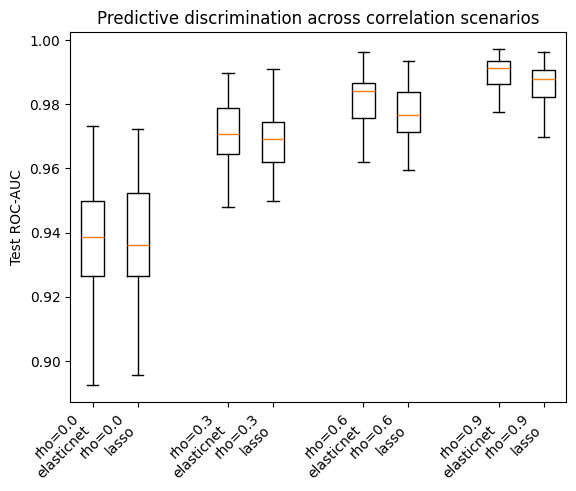

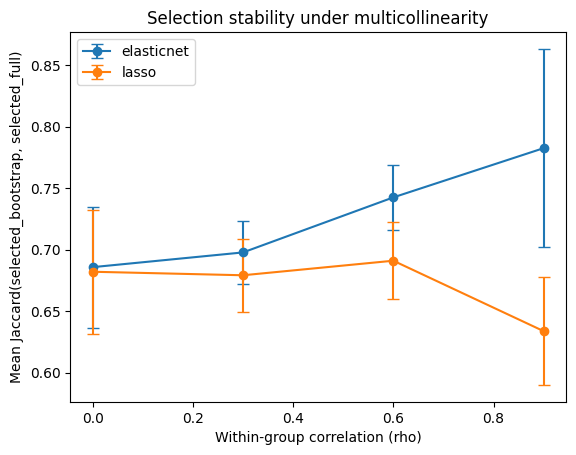

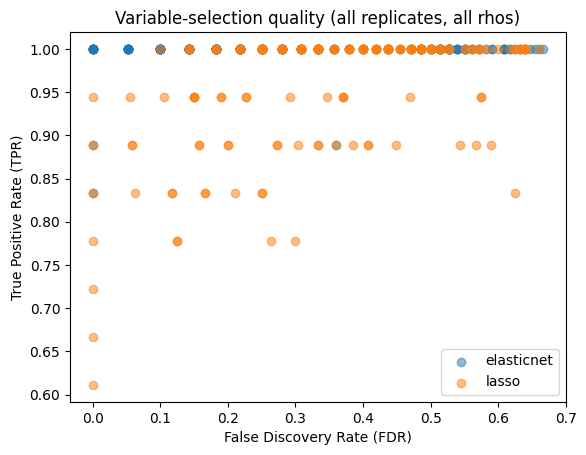

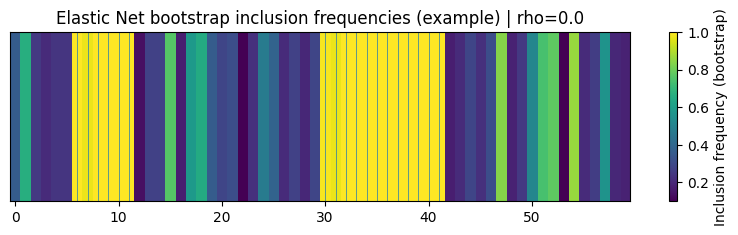

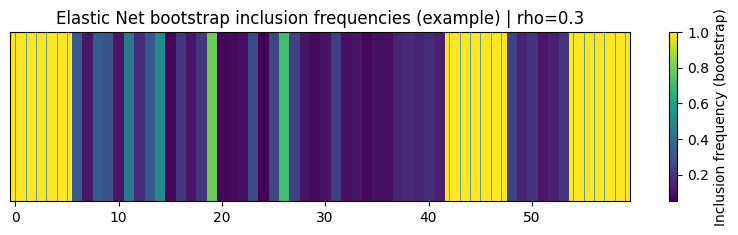

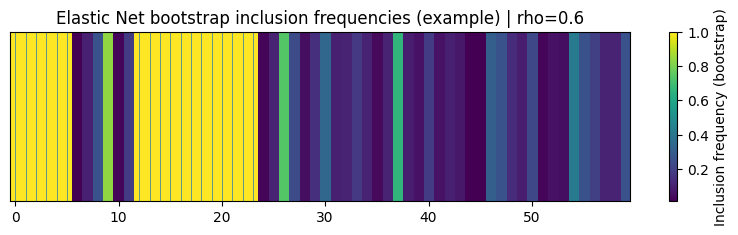

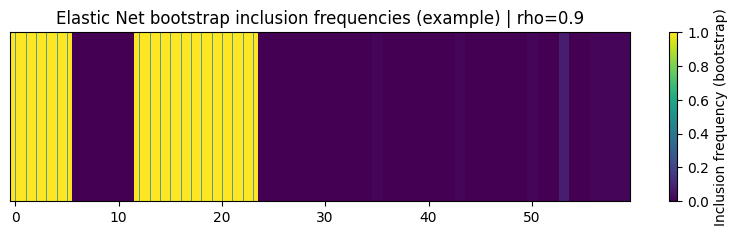

In [ ]:
# ---------- Plot 1: AUC boxplots by rho and method ----------
plt.figure()
methods = ["elasticnet", "lasso"]
positions = []
labels = []
data = []
pos = 1

for rho in rhos:
    for m in methods:
        vals = df[(df.rho==rho) & (df.method==m)]["auc"].values
        data.append(vals)
        positions.append(pos)
        labels.append(f"rho={rho}\n{m}")
        pos += 1
    pos += 1  # gap between rho blocks

plt.boxplot(data, positions=positions, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test ROC-AUC")
plt.title("Predictive discrimination across correlation scenarios")
save_fig("auc_boxplot.png")
plt.show()

# ---------- Plot 2: Stability (mean Jaccard) vs rho ----------
plt.figure()
for m in methods:
    sub = (df[df.method==m].groupby("rho")["mean_jaccard_to_full"]
           .agg(["mean","std"]).reindex(rhos))
    plt.errorbar(sub.index, sub["mean"], yerr=sub["std"], marker="o", capsize=4, label=m)

plt.xlabel("Within-group correlation (rho)")
plt.ylabel("Mean Jaccard(selected_bootstrap, selected_full)")
plt.title("Selection stability under multicollinearity")
plt.legend()
save_fig("stability_jaccard_vs_rho.png")
plt.show()

# ---------- Plot 3: TPR/FDR tradeoff scatter (each replicate) ----------
plt.figure()
for m in methods:
    sub = df[df.method==m]
    plt.scatter(sub["FDR"], sub["TPR"], alpha=0.5, label=m)

plt.xlabel("False Discovery Rate (FDR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Variable-selection quality (all replicates, all rhos)")
plt.legend()
save_fig("tpr_fdr_scatter.png")
plt.show()

# ---------- Plot 4: Example inclusion-frequency heatmap (elastic net) ----------
# (one example per rho; you can replicate for lasso too by storing it similarly)
for rho, ex in example_heatmaps.items():
    incl = ex["elasticnet_incl"]
    beta_true = ex["beta_true"]

    plt.figure(figsize=(10,2.2))
    plt.imshow(incl[np.newaxis, :], aspect="auto")
    plt.yticks([])
    plt.colorbar(label="Inclusion frequency (bootstrap)")
    plt.title(f"Elastic Net bootstrap inclusion frequencies (example) | rho={rho}")
    # mark true signals
    true_idx = np.where(beta_true!=0)[0]
    for j in true_idx:
        plt.axvline(j, linewidth=0.5)

    save_fig(f"heatmap_inclusion_elasticnet_rho_{rho}.png")
    plt.show()


(Cell 6) Save  top-features table for one run

In [ ]:
# Pick one rho to export detailed feature-level stability summary (elastic net)
rho_pick = 0.9
cfg = SimConfig(**{**cfg_base.__dict__, "rho": float(rho_pick)})
X, y, beta_true, active_groups, groups, is_true = simulate_dataset(cfg, seed=999)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30, random_state=999, stratify=y)
pipe_en, bp_en, coef_en = fit_cv_model(Xtr, ytr, method="elasticnet", seed=999)
stab_en = bootstrap_stability(Xtr, ytr, pipe_en, B=120, seed=2024)

detail = pd.DataFrame({
    "feature": np.arange(X.shape[1]),
    "group": groups,
    "beta_true": beta_true,
    "coef_full": stab_en["full_coef"],
    "OR_median": stab_en["OR_med"],
    "OR_2.5%": stab_en["OR_lo"],
    "OR_97.5%": stab_en["OR_hi"],
    "incl_freq": stab_en["incl_freq"],
    "sign_stab": stab_en["sign_stab"],
    "is_true_signal": (beta_true!=0).astype(int)
}).sort_values(["incl_freq","sign_stab"], ascending=False)

top20 = detail.head(20).reset_index(drop=True)
display(top20)
save_table(top20, "top20_feature_stability_elasticnet_rho_0p9")
print(top20.to_markdown(index=False))


,feature,group,beta_true,coef_full,OR_median,OR_2.5%,OR_97.5%,incl_freq,sign_stab,is_true_signal
0,6,1,1.0,0.255887,1.283344,1.183416,1.384027,1.000000,1.000000,1
1,7,1,1.0,0.233566,1.256695,1.171278,1.355455,1.000000,1.000000,1
2,8,1,1.0,0.233303,1.270464,1.167562,1.367826,1.000000,1.000000,1
3,9,1,1.0,0.230199,1.257723,1.173515,1.348999,1.000000,1.000000,1
4,10,1,1.0,0.206665,1.239922,1.121169,1.324191,1.000000,1.000000,1
5,11,1,1.0,0.190842,1.200166,1.123117,1.301301,1.000000,1.000000,1
6,12,2,1.0,0.228838,1.254144,1.165505,1.350940,1.000000,1.000000,1
7,13,2,1.0,0.220051,1.248927,1.156870,1.358873,1.000000,1.000000,1
8,14,2,1.0,0.189003,1.212368,1.112839,1.318417,1.000000,1.000000,1
9,15,2,1.0,0.216877,1.235807,1.154802,1.332405,1.000000,1.000000,1


|   feature |   group |   beta_true |   coef_full |   OR_median |   OR_2.5% |   OR_97.5% |   incl_freq |   sign_stab |   is_true_signal |
|----------:|--------:|------------:|------------:|------------:|----------:|-----------:|------------:|------------:|-----------------:|
|         6 |       1 |           1 |   0.255887  |     1.28334 |   1.18342 |    1.38403 |    1        |    1        |                1 |
|         7 |       1 |           1 |   0.233566  |     1.2567  |   1.17128 |    1.35546 |    1        |    1        |                1 |
|         8 |       1 |           1 |   0.233303  |     1.27046 |   1.16756 |    1.36783 |    1        |    1        |                1 |
|         9 |       1 |           1 |   0.230199  |     1.25772 |   1.17351 |    1.349   |    1        |    1        |                1 |
|        10 |       1 |           1 |   0.206665  |     1.23992 |   1.12117 |    1.32419 |    1        |    1        |                1 |
|        11 |       1 |           

(Cell 7) Zip everything + download

In [ ]:
zip_path = shutil.make_archive(OUTDIR, "zip", OUTDIR)
print("Zipped to:", zip_path)

if IN_COLAB:
    files.download(zip_path)


Zipped to: /content/sim_outputs_20260213_050028.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>